# 0. Imports and Dataset Load

In [2]:
# %pip install dynamax
# %pip install git+https://github.com/probml/rebayes.git
# %pip install jax-dataloader
# %pip install jax-tqdm
# %pip install flax
# %pip install avalanche-lib
# %pip install bayesian-optimization

In [3]:
from functools import partial
from pathlib import Path
import pickle

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import trange
import jax_dataloader.core as jdl
import optax

from rebayes.low_rank_filter.lofi import LoFiParams
from demos.showdown.classification import (
    permuted_mnist as core,
    classification_train as benchmark,
    hparam_tune_clf as hpt,
)

In [4]:
data_kwargs = {
    'n_tasks': 100,
    'ntrain_per_task': 200,
    'nval_per_task': 1_000,
    'ntest_per_task': 1_000,
}

dataset = benchmark.load_permuted_mnist_dataset(**data_kwargs, fashion=True)

In [5]:
output_path = Path(Path.cwd(), 'output', 'permuted-mnist', 'experiment')
output_path.mkdir(parents=True, exist_ok=True)

In [6]:
features = [400, 400, 10]
model_dict = benchmark.init_model(type='mlp', features=features)

In [7]:
(Xtr, Ytr), (Xval, Yval), (Xte, Yte) = dataset.values()

In [8]:
# Measure average cumulative tasks performance over 50 tasks
val_after = 50
X_warmup_tr = Xtr[:val_after*data_kwargs["ntrain_per_task"]]
Y_warmup_tr = Ytr[:val_after*data_kwargs["ntrain_per_task"]]
warmup_train = (X_warmup_tr, Y_warmup_tr)

X_warmup_val = Xval[:val_after*data_kwargs["nval_per_task"]]
Y_warmup_val = Yval[:val_after*data_kwargs["nval_per_task"]]
warmup_val = (X_warmup_val, Y_warmup_val)

In [9]:
# # Measure in-task performance after 20 tasks
# val_after = 20
# X_warmup_tr = Xtr[:val_after*data_kwargs["ntrain_per_task"]]
# Y_warmup_tr = Ytr[:val_after*data_kwargs["ntrain_per_task"]]
# warmup_train = (X_warmup_tr, Y_warmup_tr)

# X_warmup_val = Xval[(val_after-1)*data_kwargs["nval_per_task"]:val_after*data_kwargs["nval_per_task"]]
# Y_warmup_val = Yval[(val_after-1)*data_kwargs["nval_per_task"]:val_after*data_kwargs["nval_per_task"]]
# warmup_val = (X_warmup_val, Y_warmup_val)

In [10]:
ll_calback = partial(benchmark.eval_callback, evaluate_fn=benchmark.mnist_evaluate_ll)

In [11]:
# ll_calback = partial(
#     benchmark.osa_eval_callback, 
#     evaluate_fn=lambda y_pred, y: -1 * optax.softmax_cross_entropy(y_pred, y).mean(),
# )

# 1. FDEKF

## 1.1 Hyperparam Tuning

In [11]:
pbounds={
    'log_init_cov': (-10, 1),
    'log_dynamics_weights': (-50, 0),
    'log_dynamics_cov': (-50, 0),
    'log_alpha': (-50, 0),
}
fdekf_model = 'fdekf'

In [122]:
fdekf_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, warmup_train, warmup_val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'fdekf'
)

In [123]:
%%time
fdekf_optimizer.maximize(
    init_points=50,
    n_iter=50,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -883.2    | -4.156    | -20.57    | -36.75    | -1.385    |
| 2         | -298.4    | -4.1      | -8.632    | -13.6     | -7.135    |
| 3         | -791.7    | -4.412    | -36.96    | -11.68    | -7.123    |
| 4         | -2.28     | -43.89    | -30.7     | -7.996    | -6.94     |
| 5         | -1.494    | -46.5     | -18.34    | -20.76    | -3.606    |
| 6         | -2.039    | -16.14    | -15.64    | -28.05    | -6.47     |
| 7         | -1.957    | -21.47    | -26.01    | -6.946    | -0.8171   |
| 8         | -2.179    | -44.71    | -46.98    | -20.16    | -1.284    |
| 9         | -1.84     | -38.68    | -23.24    | -43.2     | -5.905    |
| 10        | -1.703    | -42.4     | -28.51    | -10.36    | -5.523    |
| 11        | -112.8    | -41.11    | -4.537    | -22.73    | -8.895    |
| 12        | -386.9    | -14.06    | 

## 1.2 Test-Set Evaluation

In [124]:
fdekf_model = 'fdekf'
fdekf_hparams = {
    'initial_covariance': 0.010352508097518903,
    'dynamics_weights': 0.9999999940218407,
    'dynamics_covariance': 2.3315742318898394e-08,
    'dynamics_covariance_inflation_factor': 3.701360570376266e-09
}

In [125]:
# fdekf_hparams = hpt.get_best_params(fdekf_optimizer, method=fdekf_model)
fdekf_estimator = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                      fdekf_hparams, model_dict['emission_mean_function'],
                                      model_dict['emission_cov_function'], 
                                      method=fdekf_model)

In [126]:
fdekf_hparams

{'initial_covariance': 0.010352508097518903,
 'dynamics_weights': 0.9999999940218407,
 'dynamics_covariance': 2.3315742318898394e-08,
 'dynamics_covariance_inflation_factor': 3.701360570376266e-09}

In [22]:
accuracy_fn = lambda logits, label: jnp.mean(logits.argmax(axis=-1) == label)
evaluate_accuracy = partial(
    benchmark.evaluate_function,
    loss_fn=accuracy_fn
)

In [23]:
def test_acc_callback(i, bel_pre_update, bel, batch, **kwargs):
    X_test, y_test, apply_fn = kwargs["X_test"], kwargs["y_test"], kwargs["apply_fn"]
    ntest_per_batch = kwargs["ntest_per_batch"]
    
    prev_test_batch, curr_test_batch = i*ntest_per_batch, (i+1)*ntest_per_batch
    curr_X_test, curr_y_test = X_test[prev_test_batch:curr_test_batch], y_test[prev_test_batch:curr_test_batch]
    cum_X_test, cum_y_test = X_test[:curr_test_batch], y_test[:curr_test_batch]
    
    overall_accuracy = evaluate_accuracy(bel.mean, apply_fn, cum_X_test, cum_y_test)
    current_accuracy = evaluate_accuracy(bel.mean, apply_fn, curr_X_test, curr_y_test)
    task1_accuracy = evaluate_accuracy(bel.mean, apply_fn, X_test[:ntest_per_batch], y_test[:ntest_per_batch])
    result = {
        'overall': overall_accuracy,
        'current': current_accuracy,
        'task1': task1_accuracy,
    }
    return result

In [24]:
def evaluate_model(estimator, n_iter=5, bel=None):
    overall_accs, current_accs, task1_accs = [], [], []
    for i in trange(n_iter):
        # Load dataset with random permutation and random shuffle
        dataset = benchmark.load_permuted_mnist_dataset(**data_kwargs, key=i, fashion=True)
        (Xtr, Ytr), _, (Xte, Yte) = dataset.values()
        train_ds = jdl.ArrayDataset(Xtr, Ytr)
        train_loader = jdl.DataLoaderJax(
            train_ds, batch_size=data_kwargs["ntrain_per_task"], shuffle=False, drop_last=False
        )

        test_kwargs = {
            'X_test': Xte,
            'y_test': Yte,
            'ntest_per_batch': data_kwargs["ntest_per_task"],
            'apply_fn': model_dict["apply_fn"],
        }

        _, accs = estimator.scan_dataloader(
            train_loader, 
            callback=test_acc_callback, 
            bel=bel,
            callback_at_end=True,
            **test_kwargs
        )
        overall_accs.append(jnp.array([res['overall'] for res in accs]))
        current_accs.append(jnp.array([res['current'] for res in accs]))
        task1_accs.append(jnp.array([res['task1'] for res in accs]))
    
    overall_accs, current_accs, task1_accs = jnp.array(overall_accs), jnp.array(current_accs), jnp.array(task1_accs)
    overall_accs, current_accs, task1_accs = \
        overall_accs.reshape((n_iter, -1)), current_accs.reshape((n_iter, -1)), task1_accs.reshape((n_iter, -1))

    result = {
        'overall': overall_accs.mean(axis=0),
        'overall-std': overall_accs.std(axis=0),
        'current': current_accs.mean(axis=0),
        'current-std': current_accs.std(axis=0),
        'task1': task1_accs.mean(axis=0),
        'task1-std': task1_accs.std(axis=0),
    }
    
    return result


In [130]:
fdekf_res = evaluate_model(fdekf_estimator)

100%|██████████| 5/5 [01:28<00:00, 17.76s/it]


In [131]:
filename = f'fdekf_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(fdekf_res, f)

# 2. VDEKF

## 2.1 Hyperparam Tuning

In [132]:
vdekf_model = 'vdekf'

In [133]:
vdekf_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, warmup_train, warmup_val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'vdekf'
)

In [134]:
%%time
vdekf_optimizer.maximize(
    init_points=50,
    n_iter=50,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -339.4    | -4.156    | -20.57    | -36.75    | -1.385    |
| 2         | -2.633e+0 | -4.1      | -8.632    | -13.6     | -7.135    |
| 3         | -439.3    | -4.412    | -36.96    | -11.68    | -7.123    |
| 4         | -2.28     | -43.89    | -30.7     | -7.996    | -6.94     |
| 5         | -1.502    | -46.5     | -18.34    | -20.76    | -3.606    |
| 6         | -2.04     | -16.14    | -15.64    | -28.05    | -6.47     |
| 7         | -1.985    | -21.47    | -26.01    | -6.946    | -0.8171   |
| 8         | -1.878    | -44.71    | -46.98    | -20.16    | -1.284    |
| 9         | -1.843    | -38.68    | -23.24    | -43.2     | -5.905    |
| 10        | -1.704    | -42.4     | -28.51    | -10.36    | -5.523    |
| 11        | -575.4    | -41.11    | -4.537    | -22.73    | -8.895    |
| 12        | -342.1    | -14.06    | 

## 2.2 Test-Set Evaluation

In [135]:
vdekf_model = 'vdekf'
vdekf_hparams = {
    'initial_covariance': 0.015392901203046557,
    'dynamics_weights': 0.9999999999911767,
    'dynamics_covariance': 4.633245792886166e-12,
    'dynamics_covariance_inflation_factor': 1.0039872520262076e-13
}

In [136]:
# vdekf_hparams = hpt.get_best_params(vdekf_optimizer, method=vdekf_model)
vdekf_estimator = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                      vdekf_hparams, model_dict['emission_mean_function'],
                                      model_dict['emission_cov_function'], 
                                      method=vdekf_model)

In [137]:
vdekf_hparams

{'initial_covariance': 0.015392901203046557,
 'dynamics_weights': 0.9999999999911767,
 'dynamics_covariance': 4.633245792886166e-12,
 'dynamics_covariance_inflation_factor': 1.0039872520262076e-13}

In [138]:
vdekf_res = evaluate_model(vdekf_estimator)

100%|██████████| 5/5 [01:39<00:00, 19.95s/it]


In [139]:
filename = f'vdekf_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(vdekf_res, f)

# 3. LoFi (Rank 2)

## 3.1 Hyperparam Tuning

In [41]:
lofi_2_params = LoFiParams(
    memory_size=2,
    diagonal_covariance=True,
)

In [42]:
pbounds={
    'log_init_cov': (-10, 0),
    'log_dynamics_weights': (-40, 0),
    'log_dynamics_cov': (-40, 0),
    'log_alpha': (-40, 0),
}

In [43]:
lofi_2_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, warmup_train, warmup_val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'lofi', lofi_params=lofi_2_params
)

In [ ]:
%%time
lofi_2_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -2.376    | -3.325    | -16.46    | -29.4     | -2.168    |


## 3.2 Test-Set Evaluation

In [144]:
lofi_2_hparams = {
    'initial_covariance': 0.015181455367452369,
    'dynamics_weights': 0.999999938814697,
    'dynamics_covariance': 4.2311825285784173e-07,
    'dynamics_covariance_inflation_factor': 6.96219159113032e-17
}

In [145]:
# lofi_2_hparams = hpt.get_best_params(lofi_2_optimizer, method='lofi')
lofi_2_estimator = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                       lofi_2_hparams, model_dict['emission_mean_function'],
                                       model_dict['emission_cov_function'], 
                                       method='lofi', lofi_params=lofi_2_params)

In [146]:
lofi_2_hparams

{'initial_covariance': 0.015181455367452369,
 'dynamics_weights': 0.999999938814697,
 'dynamics_covariance': 4.2311825285784173e-07,
 'dynamics_covariance_inflation_factor': 6.96219159113032e-17}

In [147]:
lofi_2_res = evaluate_model(lofi_2_estimator)

100%|██████████| 5/5 [03:46<00:00, 45.32s/it]


In [148]:
filename = f'lofi_2_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(lofi_2_res, f)

# 4. LoFi (Rank 5)

## 4.1 Hyperparam Tuning

In [149]:
lofi_5_params = LoFiParams(
    memory_size=5,
    diagonal_covariance=True,
)

In [150]:
lofi_5_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, warmup_train, warmup_val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'lofi', lofi_params=lofi_5_params
)

In [151]:
%%time
lofi_5_optimizer.maximize(
    init_points=50,
    n_iter=50,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -2.317    | -3.325    | -16.46    | -29.4     | -2.168    |
| 2         | -118.1    | -3.28     | -6.906    | -10.88    | -7.395    |
| 3         | -2.31     | -3.529    | -29.57    | -9.345    | -7.385    |
| 4         | -2.303    | -35.11    | -24.56    | -6.397    | -7.218    |
| 5         | -1.256    | -37.2     | -14.68    | -16.61    | -4.188    |
| 6         | -1.57     | -12.91    | -12.51    | -22.44    | -6.791    |
| 7         | -2.303    | -17.18    | -20.81    | -5.557    | -1.652    |
| 8         | -1.403    | -35.77    | -37.58    | -16.12    | -2.076    |
| 9         | -1.978    | -30.95    | -18.59    | -34.56    | -6.278    |
| 10        | -2.216    | -33.92    | -22.81    | -8.292    | -5.93     |
| 11        | -193.2    | -32.89    | -3.63     | -18.19    | -8.995    |
| 12        | -2.199e+0 | -11.25    | 

## 4.2 Test-Set Evaluation

In [152]:
lofi_5_hparams = {
    'initial_covariance': 0.014853951398978809,
    'dynamics_weights': 0.9999999999999917,
    'dynamics_covariance': 1.1926240223102626e-08,
    'dynamics_covariance_inflation_factor': 2.2713430577311035e-11
}

In [153]:
# lofi_5_hparams = hpt.get_best_params(lofi_5_optimizer, method='lofi')
lofi_5_estimator = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                       lofi_5_hparams, model_dict['emission_mean_function'],
                                       model_dict['emission_cov_function'], 
                                       method='lofi', lofi_params=lofi_5_params)

In [154]:
lofi_5_hparams

{'initial_covariance': 0.014853951398978809,
 'dynamics_weights': 0.9999999999999917,
 'dynamics_covariance': 1.1926240223102626e-08,
 'dynamics_covariance_inflation_factor': 2.2713430577311035e-11}

In [155]:
lofi_5_res = evaluate_model(lofi_5_estimator)

100%|██████████| 5/5 [05:31<00:00, 66.32s/it]


In [156]:
filename = f'lofi_5_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(lofi_5_res, f)

# 5. Lofi (Rank 10)

## 5.1 Hyperparam Tuning

In [92]:
lofi_10_params = LoFiParams(
    memory_size=10,
    diagonal_covariance=True,
)

In [93]:
lofi_10_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, warmup_train, warmup_val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'lofi', lofi_params=lofi_10_params,
)

In [ ]:
%%time
lofi_10_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------


## 5.2 Test-Set Evaluation

In [160]:
lofi_10_hparams = {
    'initial_covariance': 0.014853951398978809,
    'dynamics_weights': 0.9999999999999917,
    'dynamics_covariance': 1.1926240223102626e-08,
    'dynamics_covariance_inflation_factor': 2.2713430577311035e-11
}

In [161]:
# lofi_10_hparams = hpt.get_best_params(lofi_10_optimizer, method='lofi')
lofi_10_estimator = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                        lofi_10_hparams, model_dict['emission_mean_function'],
                                        model_dict['emission_cov_function'], 
                                        method='lofi', lofi_params=lofi_10_params)

In [162]:
lofi_10_hparams

{'initial_covariance': 0.014853951398978809,
 'dynamics_weights': 0.9999999999999917,
 'dynamics_covariance': 1.1926240223102626e-08,
 'dynamics_covariance_inflation_factor': 2.2713430577311035e-11}

In [163]:
lofi_10_res = evaluate_model(lofi_10_estimator)

100%|██████████| 5/5 [07:38<00:00, 91.69s/it]


In [164]:
filename = f'lofi_10_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(lofi_10_res, f)

# 6. LoFi (Rank 20)

## 6.1 Hyperparam Tuning

In [165]:
lofi_20_params = LoFiParams(
    memory_size=20,
    diagonal_covariance=True,
)

In [166]:
lofi_20_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, warmup_train, warmup_val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'lofi', lofi_params=lofi_20_params
)

In [167]:
%%time
lofi_20_optimizer.maximize(
    init_points=50,
    n_iter=50,
)

|   iter    |  target   | log_alpha | log_dy... | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -2.34     | -3.325    | -16.46    | -29.4     | -2.168    |
| 2         | -48.66    | -3.28     | -6.906    | -10.88    | -7.395    |
| 3         | -2.31     | -3.529    | -29.57    | -9.345    | -7.385    |
| 4         | -2.303    | -35.11    | -24.56    | -6.397    | -7.218    |
| 5         | -1.208    | -37.2     | -14.68    | -16.61    | -4.188    |
| 6         | -1.523    | -12.91    | -12.51    | -22.44    | -6.791    |
| 7         | -2.303    | -17.18    | -20.81    | -5.557    | -1.652    |
| 8         | -1.404    | -35.77    | -37.58    | -16.12    | -2.076    |
| 9         | -1.958    | -30.95    | -18.59    | -34.56    | -6.278    |
| 10        | -2.218    | -33.92    | -22.81    | -8.292    | -5.93     |
| 11        | -255.4    | -32.89    | -3.63     | -18.19    | -8.995    |
| 12        | -1.569e+0 | -11.25    | 

## 6.2 Test-Set Evaluation

In [168]:
lofi_20_hparams = {
    'initial_covariance': 0.0130924931006984,
    'dynamics_weights': 0.999999999668324,
    'dynamics_covariance': 1.5904803018143304e-13,
    'dynamics_covariance_inflation_factor': 8.932208879081414e-16
}

In [169]:
# lofi_20_hparams = hpt.get_best_params(lofi_20_optimizer, method='lofi')
lofi_20_estimator = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                        lofi_20_hparams, model_dict['emission_mean_function'],
                                        model_dict['emission_cov_function'], 
                                        method='lofi', lofi_params=lofi_20_params)

In [170]:
lofi_20_hparams

{'initial_covariance': 0.0130924931006984,
 'dynamics_weights': 0.999999999668324,
 'dynamics_covariance': 1.5904803018143304e-13,
 'dynamics_covariance_inflation_factor': 8.932208879081414e-16}

In [171]:
lofi_20_res = evaluate_model(lofi_20_estimator)

100%|██████████| 5/5 [13:24<00:00, 160.82s/it]


In [172]:
filename = f'lofi_20_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(lofi_20_res, f)

# 7. LoFi (Rank 50)

## 7.1 Hyperparam Tuning

In [41]:
lofi_50_params = LoFiParams(
    memory_size=50,
    diagonal_covariance=True,
)

In [42]:
lofi_50_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], pbounds, 314, warmup_train, warmup_val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'lofi', lofi_params=lofi_50_params
)

In [43]:
# %%time
# lofi_50_optimizer.maximize(
#     init_points=50,
#     n_iter=50,
# )

## 7.2 Test-Set Evaluation

In [44]:
lofi_50_hparams = {
    'initial_covariance': 0.014853951398978809,
    'dynamics_weights': 0.9999999999999917,
    'dynamics_covariance': 1.1926240223102626e-08,
    'dynamics_covariance_inflation_factor': 2.2713430577311035e-11
}

In [45]:
# lofi_50_hparams = hpt.get_best_params(lofi_50_optimizer, method='lofi')
lofi_50_estimator = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                        lofi_50_hparams, model_dict['emission_mean_function'],
                                        model_dict['emission_cov_function'], 
                                        method='lofi', lofi_params=lofi_50_params)

In [46]:
lofi_50_hparams

{'initial_covariance': 0.014853951398978809,
 'dynamics_weights': 0.9999999999999917,
 'dynamics_covariance': 1.1926240223102626e-08,
 'dynamics_covariance_inflation_factor': 2.2713430577311035e-11}

In [47]:
lofi_50_res = evaluate_model(lofi_50_estimator)

100%|██████████| 5/5 [2:28:36<00:00, 1783.27s/it]


In [48]:
filename = f'lofi_50_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(lofi_50_res, f)

# 8. Online Gradient Descent

## 8.1 Hyperparam Tuning

In [12]:
rsgd_pbounds = {
    'log_lr': (-10.0, 0.0),
}

In [13]:
ogd_params = {
    'loss_fn': optax.softmax_cross_entropy,
    'buffer_size': 1,
    'dim_output': 10
}

In [14]:
ogd_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], rsgd_pbounds, 314, warmup_train, warmup_val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'sgd', **ogd_params
)

In [15]:
%%time
ogd_optimizer.maximize(
    init_points=10,
    n_iter=15,
)

|   iter    |  target   |  log_lr   |
-------------------------------------
| 1         | -1e+08    | -0.8313   |
| 2         | -1.734    | -4.115    |
| 3         | -1.939    | -7.35     |
| 4         | -2.329    | -2.168    |
| 5         | -1e+08    | -0.82     |
| 6         | -2.358    | -1.726    |
| 7         | -2.294    | -2.72     |
| 8         | -1.962    | -7.395    |
| 9         | -1e+08    | -0.8824   |
| 10        | -1.961    | -7.392    |
| 11        | -1.394    | -5.502    |
| 12        | -2.229    | -9.035    |
| 13        | -2.265    | -10.0     |
| 14        | -1.421    | -6.321    |
| 15        | -2.171    | -8.304    |
| 16        | -1.841    | -3.437    |
| 17        | -1.536    | -4.814    |
| 18        | -2.25     | -9.537    |
| 19        | -1.551    | -6.764    |
| 20        | -1.382    | -5.897    |
| 21        | -2.116    | -7.915    |
| 22        | -1.877    | -3.078    |
| 23        | -1.672    | -4.466    |
| 24        | -2.206    | -8.679    |
| 25        

## 8.2 Test-Set Evaluation

In [18]:
ogd_hparams = {
    'learning_rate': 0.0027465551960645573
}

In [19]:
# ogd_hparams = hpt.get_best_params(ogd_optimizer, method='sgd')
ogd_estimator = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                    ogd_hparams, model_dict['emission_mean_function'],
                                    model_dict['emission_cov_function'], 
                                    method='sgd', **ogd_params)

In [20]:
ogd_hparams

{'learning_rate': 0.0027465551960645573}

In [25]:
ogd_res = evaluate_model(ogd_estimator)

100%|██████████| 5/5 [02:01<00:00, 24.34s/it]


In [26]:
filename = f'ogd_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(ogd_res, f)

# 9. SGD-RB (Rank 10)

## 9.1 Hyperparam Tuning

In [27]:
sgd_10_params = {
    'loss_fn': optax.softmax_cross_entropy,
    'buffer_size': 10,
    'dim_output': 10
}

In [28]:
sgd_10_optimizer, apply_fn, n_feats = hpt.create_optimizer(
    model_dict["model"], rsgd_pbounds, 314, warmup_train, warmup_val, 
    model_dict["emission_mean_function"], model_dict["emission_cov_function"],
    ll_calback, 'sgd', **sgd_10_params
)

In [29]:
%%time
sgd_10_optimizer.maximize(
    init_points=10,
    n_iter=15,
)

|   iter    |  target   |  log_lr   |
-------------------------------------
| 1         | -1e+08    | -0.8313   |
| 2         | -2.219    | -4.115    |
| 3         | -1.6      | -7.35     |
| 4         | -1e+08    | -2.168    |
| 5         | -1e+08    | -0.82     |
| 6         | -1e+08    | -1.726    |
| 7         | -1e+08    | -2.72     |
| 8         | -1.552    | -7.395    |
| 9         | -1e+08    | -0.8824   |
| 10        | -1.53     | -7.392    |
| 11        | -2.288    | -5.382    |
| 12        | -2.067    | -10.0     |
| 13        | -1.519    | -8.927    |
| 14        | -2.044    | -4.703    |
| 15        | -1.485    | -6.261    |
| 16        | -1.469    | -8.277    |
| 17        | -1.845    | -9.525    |
| 18        | -1.639    | -5.823    |
| 19        | -1.561    | -6.753    |
| 20        | -2.149    | -4.369    |
| 21        | -1.456    | -7.9      |
| 22        | -2.264    | -5.044    |
| 23        | -1.458    | -8.618    |
| 24        | -1.994    | -9.787    |
| 25        

## 9.2 Test-Set Evaluation

In [32]:
sgd_10_hparams = {
    'learning_rate': 0.00037073959697035485
}

In [33]:
# sgd_10_hparams = hpt.get_best_params(sgd_10_optimizer, method='sgd')
sgd_10_estimator = hpt.build_estimator(model_dict['flat_params'], model_dict['apply_fn'],
                                       sgd_10_hparams, model_dict['emission_mean_function'],
                                       model_dict['emission_cov_function'], 
                                       method='sgd', **sgd_10_params)

In [34]:
sgd_10_hparams

{'learning_rate': 0.00037073959697035485}

In [35]:
sgd_10_res = evaluate_model(sgd_10_estimator)

100%|██████████| 5/5 [00:54<00:00, 10.99s/it]


In [36]:
filename = f'sgd_10_result.pkl'
with open(Path(output_path, filename), "wb") as f:
    pickle.dump(sgd_10_res, f)

# 10. Model Comparison

In [37]:
results = {
    'OGD': ogd_res,
    'SGD-10': sgd_10_res,
    # 'FDEKF': fdekf_res,
    # 'VDEKF': vdekf_res,
    # 'LoFi-1': lofi_1_res,
    # 'LoFi-5': lofi_5_res,
    # 'LoFi-10': lofi_10_res,
    # 'LoFi-20': lofi_20_res,
    # 'LoFi-50': lofi_50_res,
}

In [38]:
# boundaries = [i for i in range(600, (600*10)+1, 600)]

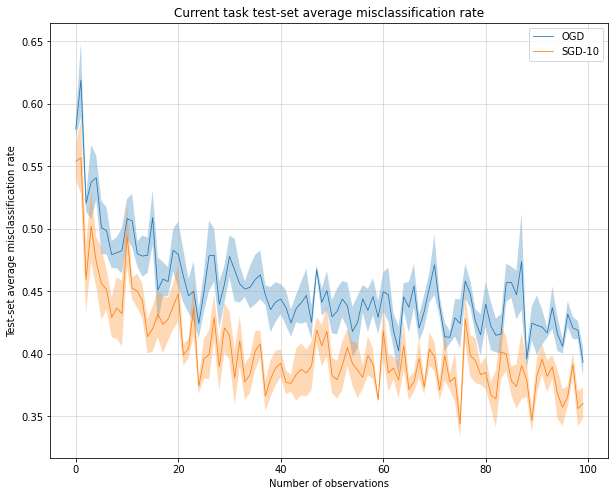

In [39]:
fig, ax = plt.subplots(figsize=(10,8))
for key, val in results.items():
    ax.plot(1.0 - val['current'], label=key, linewidth=0.8)
    ax.fill_between(
        jnp.arange(val['current'].shape[0]),
        1.0 - val['current'] - val['current-std'] / jnp.sqrt(5),
        1.0 - val['current'] + val['current-std'] / jnp.sqrt(5),
        alpha=0.3
    )
# Task boundaries
# for b in boundaries:
#     ax.axvline(x=b, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('Number of observations')
ax.set_ylabel('Test-set average misclassification rate');
ax.set_title(f'Current task test-set average misclassification rate')
ax.grid(alpha=0.5)
ax.legend();

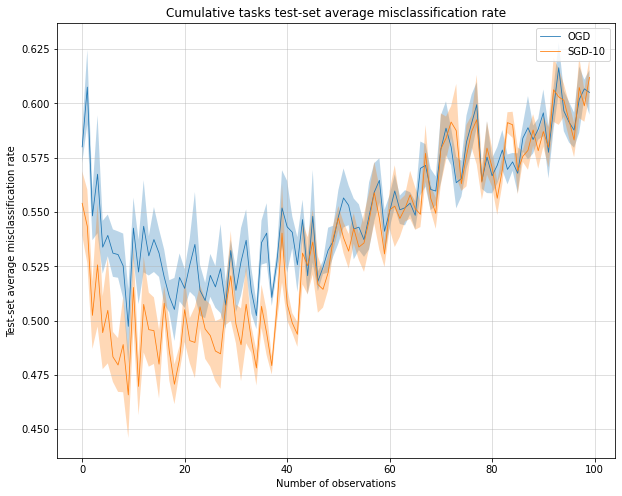

In [40]:
fig, ax = plt.subplots(figsize=(10,8))
for key, val in results.items():
    ax.plot(1.0 - val['overall'], label=key, linewidth=0.8)
    ax.fill_between(
        jnp.arange(val['overall'].shape[0]),
        1.0 - val['overall'] - val['overall-std']/jnp.sqrt(5),
        1.0 - val['overall'] + val['overall-std']/jnp.sqrt(5),
        alpha=0.3
    )
# Task boundaries
# for b in boundaries:
#     ax.axvline(x=b, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('Number of observations')
ax.set_ylabel('Test-set average misclassification rate');
ax.set_title(f'Cumulative tasks test-set average misclassification rate')
ax.grid(alpha=0.5)
ax.legend();
# fig.savefig(f'{output_path}_{name}.pdf', bbox_inches='tight')